In [1]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import numpy as np
from netCDF4 import Dataset

import seaborn as sns



import matplotlib.pyplot as plt

path = os.getcwd()

import tensorflow as tf
from tensorflow.python.client import device_lib

print(tf.__version__)
print(device_lib.list_local_devices())


2.8.0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5641061197478764823
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3667263488
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13667542151589277025
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


## 예측모델

### 데이터셋 구축

In [2]:
# In[] SMOKE-CMAQ
# CMAQ 연평균 PM농도
pm2_5 = np.array([])

for i in range(1,120):
    a = 'ACONC.' + str(i)
    nc = Dataset(a, 'r')
    pm2_5 = np.append(pm2_5, np.array([[[nc.variables['PM2_5']]]]))
    
pm2_5 = np.reshape(pm2_5, [119,82,67])
pm2_5 = pm2_5[:,8:-10,2:-1]
pm2_5 = np.reshape(pm2_5, [119,64,64]) # convolution 연산을 위해

pm = pm2_5


y1 = np.array([])
y2 = np.array([])
y3 = np.array([])
y4 = np.array([])
y5 = np.array([])
y6 = np.array([])

for i in range(1,120):
    a = 'EMIS_AVG.' + str(i)
    nc = Dataset(a, 'r')
    y1 = np.append(y1, np.array([[[nc.variables['SO2']]]]))
    y2 = np.append(y2, np.array([[[nc.variables['PM2_5']]]]))
    y3 = np.append(y3, np.array([[[nc.variables['NOx']]]]))
    y4 = np.append(y4, np.array([[[nc.variables['VOCs']]]]))
    y5 = np.append(y5, np.array([[[nc.variables['NH3']]]]))
    y6 = np.append(y6, np.array([[[nc.variables['CO']]]]))
    
y1 = np.reshape(y1, [119,82,67])
y1 = y1[:,8:-10,2:-1]
y1 = np.reshape(y1, [119,64,64])
y1_max = np.max(y1)
y1_min = np.min(y1)

y2 = np.reshape(y2, [119,82,67])
y2 = y2[:,8:-10,2:-1]
y2 = np.reshape(y2, [119,64,64])
y2_max = np.max(y2)
y2_min = np.min(y2)

y3 = np.reshape(y3, [119,82,67])
y3 = y3[:,8:-10,2:-1]
y3 = np.reshape(y3, [119,64,64])
y3_max = np.max(y3)
y3_min = np.min(y3)

y4 = np.reshape(y4, [119,82,67])
y4 = y4[:,8:-10,2:-1]
y4 = np.reshape(y4, [119,64,64])
y4_max = np.max(y4)
y4_min = np.min(y4)

y5 = np.reshape(y5, [119,82,67])
y5 = y5[:,8:-10,2:-1]
y5 = np.reshape(y5, [119,64,64])
y5_max = np.max(y5)
y5_min = np.min(y5)
    
y6 = np.reshape(y6, [119,82,67])
y6 = y6[:,8:-10,2:-1]
y6 = np.reshape(y6, [119,64,64])


def pm_data():
    a = np.concatenate((y3,y1,y4,y5), axis=0) # PM2.5, SO2, NH3
    a = np.reshape(a,[4,119,64,64]) # data generation for CNN ??
    a = np.transpose(a, (1,2,3,0)) # CNN 학습을 위한 순서변경
    print(np.shape(a))
    
    y = pm
    
    y = np.reshape(y, [119,64,64,1]) # CNN output data
    x_train = a[0:70]
    y_train = y[0:70]
    x_test = a[70:]
    pm2_5 = y[70:]
    return x_train, y_train, x_test, pm2_5, a, y


pm_data1 = pm_data()
x_train, y_train, x_test, pm2_5, a, y = pm_data1[0], pm_data1[1], pm_data1[2], pm_data1[3], pm_data1[4], pm_data1[5]#, pm_data1[6], pm_data1[7] 


(119, 64, 64, 4)


In [3]:
x_train.shape

(70, 64, 64, 4)

### 예측네트워크 구축

In [4]:
class CBR2d(tf.keras.layers.Layer):
    def __init__(self, out_channels,kernel_size = 3):
        super(CBR2d, self).__init__()
        self.cnn_layer = tf.keras.layers.Conv2D(out_channels, kernel_size, activation='relu', padding='same')
        self.batch_layer = tf.keras.layers.BatchNormalization()
              
    def call(self, inputs):
        cnn_feat_x = self.cnn_layer(inputs)
        batched_feat = self.batch_layer(cnn_feat_x)
        return batched_feat

class Unet(tf.keras.Model): 
    def __init__(self,): 
        super(Unet, self).__init__()

        self.enc1_1 = CBR2d(out_channels = 128) 
        self.enc1_2 = CBR2d(out_channels=128)
            
        self.pool1 = tf.keras.layers.MaxPool2D(pool_size=(2,2), )
        
        self.enc2_1 = CBR2d(out_channels=256)
        self.enc2_2 = CBR2d(out_channels=256)
        
        self.pool2 = tf.keras.layers.MaxPool2D(pool_size=(2,2), )
        
        self.enc3_1 = CBR2d(out_channels=512)
        self.enc3_2 = CBR2d(out_channels=512)
        self.pool3 = tf.keras.layers.MaxPool2D(pool_size=(2,2), )
        
        
        self.enc4_1 = CBR2d(out_channels=1024)

        self.dec4_1 = CBR2d(out_channels=512)

        self.unpool3 = tf.keras.layers.Conv2DTranspose(filters=512, kernel_size=2,strides=(2, 2))

        self.dec3_2 = CBR2d(out_channels=512)
        self.dec3_1 = CBR2d(out_channels=256)

        self.unpool2 = tf.keras.layers.Conv2DTranspose(filters=256, kernel_size=2,strides=(2, 2))

        self.dec2_2 = CBR2d(out_channels=256)
        self.dec2_1 = CBR2d(out_channels=128)

        self.unpool1 = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=2,strides=(2, 2))

        self.dec1_2 = CBR2d(out_channels=128)
        self.dec1_1 = CBR2d(out_channels=128)

        self.outlayer = tf.keras.layers.Conv2D(1,kernel_size = 1)
              
    def call(self, input): 
      
        enc1_1 = self.enc1_1(input)
        enc1_2 = self.enc1_2(enc1_1)
      
        pool1 = self.pool1(enc1_2)

        enc2_1 = self.enc2_1(pool1)
        enc2_2 = self.enc2_2(enc2_1)
        pool2= self.pool2(enc2_2)
  
        enc3_1 = self.enc3_1(pool2)
        enc3_2 = self.enc3_2(enc3_1)
        pool3= self.pool3(enc3_2)

        enc4_1 = self.enc4_1(pool3)
        dec4_1 = self.dec4_1(enc4_1)
       
        unpool3 = self.unpool3(dec4_1)
    
        cat3 = tf.keras.layers.Concatenate(axis=3)([unpool3, enc3_2]) # dim = [0:batch, 1:channel, 2:height, 3:width]
        dec3_2 = self.dec3_2(cat3)
        dec3_1 = self.dec3_1(dec3_2)
        
        unpool2 = self.unpool2(dec3_1)
        
        cat2 = tf.keras.layers.Concatenate(axis=3)([unpool2, enc2_2]) # dim = [0:batch, 1:channel, 2:height, 3:width]
        dec2_2 = self.dec2_2(cat2)
        dec2_1 = self.dec2_1(dec2_2)
        
        unpool1 = self.unpool1(dec2_1)
        
        cat1 = tf.keras.layers.Concatenate(axis=3)([unpool1, enc1_2]) # dim = [0:batch, 1:channel, 2:height, 3:width]
        dec1_2 = self.dec1_2(cat1)
        dec1_1 = self.dec1_1(dec1_2)
        
        x = self.outlayer(dec1_1)
        return x

@tf.function()
def train_step(input, label, network, loss_fun):
  
  with tf.GradientTape() as tape:
    ##로스 계산
    pred = network(input)
    
    loss = loss_fun(label, pred)
  grads = tape.gradient(loss, network.trainable_variables)
  optimizer.apply_gradients(zip(grads, network.trainable_variables))
  return loss



loss = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(0.0001)

x_train_tensor = tf.convert_to_tensor(x_train,dtype = float)
x_test_tensor = tf.convert_to_tensor(x_test,dtype = float)
y_train_resize_tensor = tf.convert_to_tensor(y_train,dtype = float)
y_test_resize_tensor = tf.convert_to_tensor(pm2_5,dtype = float)

batch_size = 20
epoch = 100
buffer_len = len(x_train_tensor)
n_run = np.ceil(len(x_train_tensor)/batch_size)

train_dataset = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(x_train_tensor), tf.data.Dataset.from_tensor_slices(y_train_resize_tensor),))
shuffled_dataset = train_dataset.shuffle(buffer_size=buffer_len)

net_1 = Unet()
# test_net = Unet()
# pred = test_net(x_train)

In [5]:
for epoc in range(epoch):
    count = 0

    for batch in shuffled_dataset.batch(batch_size).take(n_run):

        count += 1
        mse_loss = train_step(batch[0],batch[1], net_1,loss).numpy()
        print(f"batch: {count}/{n_run} ---epoch: {epoc}/{epoch}--- mse-loss: {mse_loss}")

batch: 1/4.0 ---epoch: 0/100--- mse-loss: 177.7935791015625
batch: 2/4.0 ---epoch: 0/100--- mse-loss: 178.6595916748047
batch: 3/4.0 ---epoch: 0/100--- mse-loss: 176.5014190673828
batch: 4/4.0 ---epoch: 0/100--- mse-loss: 177.52450561523438
batch: 1/4.0 ---epoch: 1/100--- mse-loss: 175.2298126220703
batch: 2/4.0 ---epoch: 1/100--- mse-loss: 172.6475372314453
batch: 3/4.0 ---epoch: 1/100--- mse-loss: 168.0002899169922
batch: 4/4.0 ---epoch: 1/100--- mse-loss: 155.26780700683594
batch: 1/4.0 ---epoch: 2/100--- mse-loss: 126.8311538696289
batch: 2/4.0 ---epoch: 2/100--- mse-loss: 72.22264099121094
batch: 3/4.0 ---epoch: 2/100--- mse-loss: 46.373046875
batch: 4/4.0 ---epoch: 2/100--- mse-loss: 47.218475341796875
batch: 1/4.0 ---epoch: 3/100--- mse-loss: 31.70989990234375
batch: 2/4.0 ---epoch: 3/100--- mse-loss: 40.662559509277344
batch: 3/4.0 ---epoch: 3/100--- mse-loss: 42.61640930175781
batch: 4/4.0 ---epoch: 3/100--- mse-loss: 34.02693176269531
batch: 1/4.0 ---epoch: 4/100--- mse-loss:

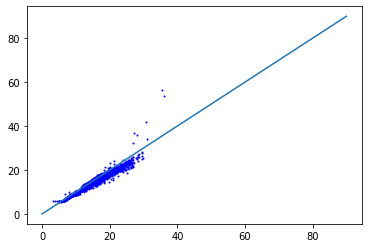

In [6]:
pre = net_1(x_test_tensor)
plt.plot(pre.numpy()[0][::-1].reshape(-1), y_test_resize_tensor.numpy()[0][::-1].reshape(-1),'bo', markersize=1)
plt.plot([0,90],[0,90])


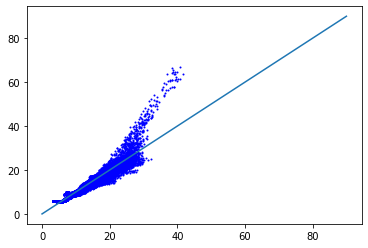

In [7]:
plt.plot(pre.numpy()[::-1].reshape(-1), y_test_resize_tensor.numpy()[::-1].reshape(-1),'bo', markersize=1)
plt.plot([0,90],[0,90])

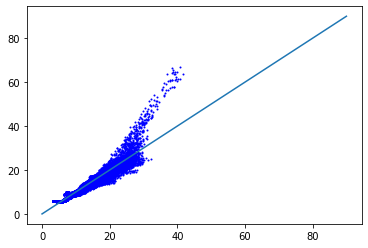

In [8]:
plt.plot(pre.numpy()[::-1].reshape(-1), y_test_resize_tensor.numpy()[::-1].reshape(-1),'bo', markersize=1)
plt.plot([0,90],[0,90])

<AxesSubplot: >

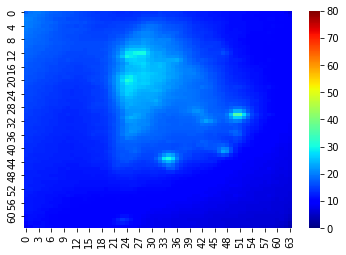

In [9]:
sns.heatmap(pre.numpy()[0,:,:,0][::-1], cmap = 'jet',vmin=0, vmax=80)

<AxesSubplot: >

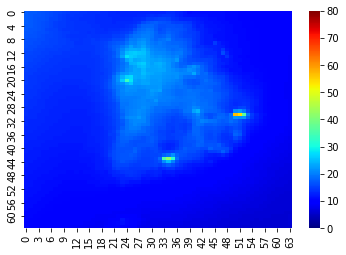

In [10]:
sns.heatmap(y_test_resize_tensor.numpy()[0,:,:,0][::-1], cmap = 'jet',vmin=0, vmax=80)

### explain_answer_network
 - explainer에는 원본 인풋이 들어감
 - explainer의 아웃풋과 epsilon에 따른 정답 or 오답 이미지 주어짐(예측네트워크의 아웃풋)
 - answer network는 0,1을 도출(정답 or 오답,이또한 epsilon greedy하게)
 - 잘 맞춘경우를 골라 buffer화 시키고 이를 통해 answer net 학습
 - answer net의 성능을 손실함수로하여 explainer 학습
 - explainer의 가중치도 지속적으로 변하므로 조금씩 가중치를 학습하도록함

In [11]:
class Unet_explain(tf.keras.Model): 
    def __init__(self,): 
        super(Unet_explain, self).__init__()

        self.enc1_1 = CBR2d(out_channels = 128) 
        self.enc1_2 = CBR2d(out_channels=128)
            
        self.pool1 = tf.keras.layers.MaxPool2D(pool_size=(2,2), )
        
        self.enc2_1 = CBR2d(out_channels=256)
        self.enc2_2 = CBR2d(out_channels=256)
        
        self.pool2 = tf.keras.layers.MaxPool2D(pool_size=(2,2), )
        
        self.enc3_1 = CBR2d(out_channels=512)
        self.enc3_2 = CBR2d(out_channels=512)
        self.pool3 = tf.keras.layers.MaxPool2D(pool_size=(2,2), )
        
        
        self.enc4_1 = CBR2d(out_channels=1024)

        self.dec4_1 = CBR2d(out_channels=512)

        self.unpool3 = tf.keras.layers.Conv2DTranspose(filters=512, kernel_size=2,strides=(2, 2))

        self.dec3_2 = CBR2d(out_channels=512)
        self.dec3_1 = CBR2d(out_channels=256)

        self.unpool2 = tf.keras.layers.Conv2DTranspose(filters=256, kernel_size=2,strides=(2, 2))

        self.dec2_2 = CBR2d(out_channels=256)
        self.dec2_1 = CBR2d(out_channels=128)

        self.unpool1 = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=2,strides=(2, 2))

        self.dec1_2 = CBR2d(out_channels=128)
        self.dec1_1 = CBR2d(out_channels=128)

        self.outlayer = tf.keras.layers.Conv2D(4,kernel_size = 1)
              
    def call(self, input): 
      
        enc1_1 = self.enc1_1(input)
        enc1_2 = self.enc1_2(enc1_1)
      
        pool1 = self.pool1(enc1_2)

        enc2_1 = self.enc2_1(pool1)
        enc2_2 = self.enc2_2(enc2_1)
        pool2= self.pool2(enc2_2)
  
        enc3_1 = self.enc3_1(pool2)
        enc3_2 = self.enc3_2(enc3_1)
        pool3= self.pool3(enc3_2)

        enc4_1 = self.enc4_1(pool3)
        dec4_1 = self.dec4_1(enc4_1)
       
        unpool3 = self.unpool3(dec4_1)
    
        cat3 = tf.keras.layers.Concatenate(axis=3)([unpool3, enc3_2]) # dim = [0:batch, 1:channel, 2:height, 3:width]
        dec3_2 = self.dec3_2(cat3)
        dec3_1 = self.dec3_1(dec3_2)
        
        unpool2 = self.unpool2(dec3_1)
        
        cat2 = tf.keras.layers.Concatenate(axis=3)([unpool2, enc2_2]) # dim = [0:batch, 1:channel, 2:height, 3:width]
        dec2_2 = self.dec2_2(cat2)
        dec2_1 = self.dec2_1(dec2_2)
        
        unpool1 = self.unpool1(dec2_1)
        
        cat1 = tf.keras.layers.Concatenate(axis=3)([unpool1, enc1_2]) # dim = [0:batch, 1:channel, 2:height, 3:width]
        dec1_2 = self.dec1_2(cat1)
        dec1_1 = self.dec1_1(dec1_2)
        
        x = self.outlayer(dec1_1)
        return x

In [46]:
class AnswerNetwork(tf.keras.Model): 
    def __init__(self,): 
        super(AnswerNetwork, self).__init__()

        self.enc1_1 = CBR2d(out_channels = 64) 
        self.enc1_2 = CBR2d(out_channels=64)
            
        self.pool1 = tf.keras.layers.MaxPool2D(pool_size=(3,3), )
        
        self.enc2_1 = CBR2d(out_channels=128)
        self.enc2_2 = CBR2d(out_channels=128)
        
        self.pool2 = tf.keras.layers.MaxPool2D(pool_size=(3,3), )
        
        self.enc3_1 = CBR2d(out_channels=256)
        self.enc3_2 = CBR2d(out_channels=256)

        self.flat1 = tf.keras.layers.Flatten()

        self.dence1 = tf.keras.layers.Dense(256, activation='relu')
        self.dence2 = tf.keras.layers.Dense(64, activation='sigmoid')
        self.dence_out = tf.keras.layers.Dense(1, activation='relu')
        
        
      
              
    def call(self, input): 
      
        enc1_1 = self.enc1_1(input)
        enc1_2 = self.enc1_2(enc1_1)

        enc2_1 = self.enc2_1(self.pool1(enc1_2))
        enc2_2 = self.enc2_2(enc2_1)

        enc3_1 = self.enc3_1(self.pool2(enc2_2))
        enc3_2 = self.enc3_2(enc3_1)

        flatted = self.flat1(enc3_2)
        dence_1 = self.dence1(flatted)
        
# tf.keras.layers.BatchNormalization()
        dence_2 = self.dence2(dence_1)
        dence_out = self.dence_out(dence_2)
      
      
        return dence_out

In [47]:
# 데이터셋 구축
train_pred_tensor = net_1(x_train_tensor)

net_explain = Unet_explain()
net_answer = AnswerNetwork()

explainer_input = tf.concat([x_train_tensor,train_pred_tensor], axis = 3)


In [48]:
explainer_output = net_explain(explainer_input)

In [49]:
test = net_answer(explainer_output)

In [50]:
test

<tf.Tensor: shape=(70, 1), dtype=float32, numpy=
array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)>

In [52]:
len(explainer_output)

70

In [51]:
tf.reshape(test,[70,-1])

<tf.Tensor: shape=(70, 12544), dtype=float32, numpy=
array([[0.00706975, 0.        , 0.00123703, ..., 0.00341977, 0.        ,
        0.02046143],
       [0.00716005, 0.        , 0.00123915, ..., 0.00344203, 0.        ,
        0.02078434],
       [0.00705842, 0.        , 0.00112764, ..., 0.0036431 , 0.        ,
        0.02163046],
       ...,
       [0.00679946, 0.        , 0.00098948, ..., 0.00363061, 0.        ,
        0.02108964],
       [0.00695778, 0.        , 0.00132306, ..., 0.00375032, 0.        ,
        0.02210704],
       [0.00720736, 0.        , 0.00120452, ..., 0.0035943 , 0.        ,
        0.02132215]], dtype=float32)>

In [ ]:
# explainNet에 좋은 설명이라는 피드백을 주는 방법
# 설명을 통해 다른 타겟과 정답타켓을 구분할 수 있는 것.

